### Create dataset from the cityscape files

In [1]:
import numpy as np
%run cityscape_dataset_maker.ipynb

cityscape has three sections :

val - 500 images

test - 1525 images

train - 2975 images

In [2]:
get_images('M:/Documents/GitHub/Projet-object-detection-2A/datasets/cityscape/leftImg8bit_trainvaltest/leftImg8bit/valModified','M:/Documents/GitHub/Projet-object-detection-2A/datasets/cityscape/gtFine_trainvaltest/gtFine/valModified')

In [3]:
cars_array, pedestrians_array, others_array, others_labels_array = dataset_maker()

In [4]:
def resize_images(array, new_dim):
    resized_array = []
    for i in range(array.shape[0]):
        resized_array.append(cv2.resize(array[i], new_dim))
    return np.array(resized_array)

In [5]:
img_size = 96


cars_array = resize_images(cars_array, (img_size,img_size))
pedestrians_array = resize_images(pedestrians_array, (img_size,img_size))
others_array = resize_images(others_array, (img_size,img_size))

(2031, 96, 96, 3)


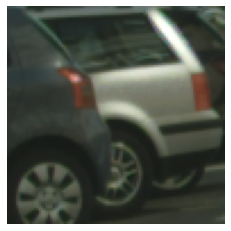

In [6]:
print(cars_array.shape)
plt.axis("off")
plt.imshow(cars_array[np.random.randint(0,cars_array.shape[0])])

(435, 96, 96, 3)


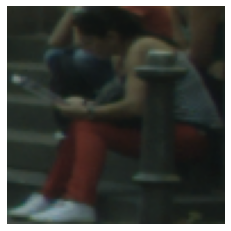

In [7]:
print(pedestrians_array.shape)
plt.axis("off")
plt.imshow(pedestrians_array[np.random.randint(0,pedestrians_array.shape[0])])

(7218, 96, 96, 3)
vegetation


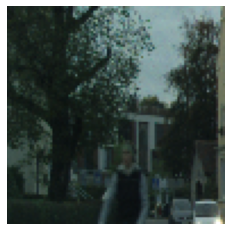

In [8]:
print(others_array.shape)
plt.axis("off")
random_index = np.random.randint(0,others_array.shape[0])
print(others_labels_array[random_index])
plt.imshow(others_array[random_index])

In [9]:
#arrays of images to training set
X_train = np.concatenate((cars_array, pedestrians_array, others_array), axis=0)
y_train = np.concatenate((np.zeros(cars_array.shape[0]), np.ones(pedestrians_array.shape[0]), np.full(others_array.shape[0],2)), axis=0)

In [10]:
from tensorflow.keras.utils import to_categorical
# to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)

In [11]:
#shuffle the data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [12]:
#split the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

### Convolutive Neural Networks

In [13]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12986889919812473752
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6945177600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9634676229974162875
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:1c:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [15]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU

In [16]:
num_classes = 3

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=(img_size,img_size,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [18]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(),metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                    

In [20]:
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
273/273 [==============================] - 6s 16ms/step - loss: 5.3671 - accuracy: 0.7970 - val_loss: 0.3559 - val_accuracy: 0.9009
Epoch 2/10
273/273 [==============================] - 3s 11ms/step - loss: 0.4381 - accuracy: 0.8943 - val_loss: 0.2786 - val_accuracy: 0.9123
Epoch 3/10
273/273 [==============================] - 3s 11ms/step - loss: 0.3292 - accuracy: 0.9113 - val_loss: 0.2637 - val_accuracy: 0.9123
Epoch 4/10
273/273 [==============================] - 3s 11ms/step - loss: 0.2589 - accuracy: 0.9266 - val_loss: 0.2315 - val_accuracy: 0.9185
Epoch 5/10
273/273 [==============================] - 3s 11ms/step - loss: 0.2077 - accuracy: 0.9391 - val_loss: 0.2120 - val_accuracy: 0.9216
Epoch 6/10
273/273 [==============================] - 3s 11ms/step - loss: 0.1877 - accuracy: 0.9480 - val_loss: 0.2883 - val_accuracy: 0.9298
Epoch 7/10
273/273 [==============================] - 3s 11ms/step - loss: 0.1641 - accuracy: 0.9524 - val_loss: 0.3829 - val_accuracy: 0.9164

In [21]:
model.save('../model/model_id_cityscape.h5')

## Testing

Text(0.5, 0, 'epoch')

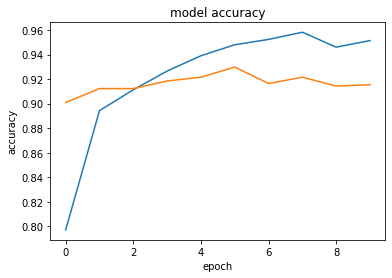

In [22]:
#graph accuracy vs val_accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [23]:
target_names = ['cars', 'pedestrians', 'others']

In [24]:
from sklearn.metrics import classification_report
predictions = model.predict(X_val)
predictions = np.argmax(predictions, axis=1)
y_val = np.argmax(y_val, axis=1)
print(classification_report(y_val, predictions, target_names=target_names))

              precision    recall  f1-score   support

        cars       0.82      0.91      0.86       201
 pedestrians       0.77      0.56      0.65        48
      others       0.95      0.94      0.95       720

    accuracy                           0.92       969
   macro avg       0.85      0.80      0.82       969
weighted avg       0.92      0.92      0.91       969

